In [12]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import Subset,DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
batch_size = 64
num_classes = 10
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

train_set = datasets.CIFAR10('/content',train=True,download=True,transform=transform)
test_set = datasets.CIFAR10('/content',train=False,download=True,transform=transform)
print(train_set.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


### Preprocessing

In [15]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = np.transpose(dataset.data,(0,3,1,2)) # get the images
    dataset_labels = dataset.targets # get the labels
    dataset_images = normalize(dataset_images)
    # dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Prepare the data

In [16]:
training_set = TensorDataset(torch.Tensor(train_images),torch.Tensor(train_labels).to(torch.int64))
testing_set = TensorDataset(torch.Tensor(test_images),torch.Tensor(test_labels).to(torch.int64))
# print(torch.Tensor(train_labels).to(torch.int64).dtype)

# prepare subset of training data per class 
training_subsets = {target: Subset(training_set,[i for i,(X,y) in enumerate(training_set) if y == target]) for _,target in train_set.class_to_idx.items()}
training_loaders = {target: DataLoader(subset,batch_size=batch_size) for target,subset in training_subsets.items()}

# prepare subset of testing data per class
testing_subsets = {target: Subset(testing_set,[i for i,(X,y) in enumerate(testing_set) if y == target]) for _,target in test_set.class_to_idx.items()}
testing_loaders = {target: DataLoader(subset,batch_size=batch_size) for target,subset in testing_subsets.items()}

In [17]:
print(training_subsets[1].dataset.tensors[1][training_subsets[2].indices])

tensor([2, 2, 2,  ..., 2, 2, 2])


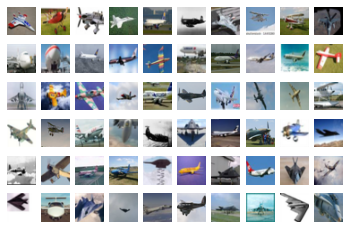

In [18]:
dataiter = iter(training_loaders[0])
images,labels = dataiter.next()
# print(images[0].shape)

figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis("off")
  plt.imshow(np.transpose(images[index].numpy(),(1,2,0)))

### Define the network

In [19]:
class NeuralNetwork(nn.Module):
  def __init__(self,classes,channels):
    super().__init__()
    self.conv1 = nn.Conv2d(channels,6,5)
    self.conv2 = nn.Conv2d(6,16,5)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*5*5,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,classes)
  
  def forward(self,x):
    # x = x.unsqueeze(1)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    # x = F.softmax(x,dim=1)
    return x

### Training the model

In [20]:
def train(model,trainloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
  model = model.to(device)
  model.train()
  for e in range(epochs):
    running_loss = 0.0
    for _,(images,labels) in enumerate(trainloader):
      (images,labels) = (images.to(device),labels.to(device))
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output,labels)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    # else:
    #   print(f"Training loss: {running_loss / len(trainloader)}")
  return model

### Testing the model

In [21]:
def test(model,testloader,classes):
  correct = np.zeros(classes,dtype=np.float64)
  total = np.zeros(classes,dtype=np.float64)
  model = model.to(device)

  with torch.no_grad():
    for images,labels in testloader:
      (images,labels) = (images.to(device),labels.to(device))
      output = model(images)
      pred = torch.argmax(output,dim=1)
      for i in range(len(labels)):
        correct[labels[i]] += (pred[i] == labels[i])
        total[labels[i]] += 1
  print(f"Accuracy for {classes} classes: {np.sum(correct) / np.sum(total)}")
  return np.divide(correct,total)

### Prepare initial training set

In [22]:
accuracy_changes = [[] for x in range(num_classes)]
x = np.linspace(0,10,num=9)

for class_of_interest in range(num_classes):
  multi_class_train_set = training_subsets[class_of_interest] # create initial datasets
  multi_class_test_set = testing_subsets[class_of_interest] # create initial datasets
  num = 1 # number of classes currently in classifier

  if class_of_interest >= 1:
    train_class_indices = training_set.tensors[1] == class_of_interest
    previous_train_class_indices = training_set.tensors[1] == 0
    training_set.tensors[1][train_class_indices] = 0
    training_set.tensors[1][previous_train_class_indices] = class_of_interest

    test_class_indices = testing_set.tensors[1] == class_of_interest
    previous_test_class_indices = testing_set.tensors[1] == 0
    testing_set.tensors[1][test_class_indices] = 0
    testing_set.tensors[1][previous_test_class_indices] = class_of_interest
    # print(training_set.tensors[1].unique())
    # print(training_subsets[2].dataset.tensors[1][training_subsets[2].indices])
    # break
  for i in range(num_classes):
    if class_of_interest == i:
      continue
    
    num += 1
    model = NeuralNetwork(num,3)
    # concat the training set of the new class with old training set
    multi_class_train_set = ConcatDataset([multi_class_train_set,training_subsets[i]])
    # concat the testing set of the new class with old testing set
    multi_class_test_set = ConcatDataset([multi_class_test_set,testing_subsets[i]])
    # define train loader
    train_loader = DataLoader(multi_class_train_set,batch_size=batch_size,shuffle=True)
    # define test loader
    test_loader = DataLoader(multi_class_test_set,batch_size=batch_size)
    # train the old model with new dataset
    model = train(model,train_loader)
    accuracies = test(model,test_loader,num)
    print(accuracies)
    accuracy_changes[class_of_interest].append(accuracies[0])
  
  
  # plt.plot(x,accuracy_changes[class_of_interest],'-s',label = f'Class {class_of_interest}')

# plt.legend()
# plt.title("Accuracy fluctuation")
# plt.show()

Accuracy for 2 classes: 0.787
[0.845 0.729]
Accuracy for 3 classes: 0.6993333333333334
[0.53  0.762 0.806]
Accuracy for 4 classes: 0.6205
[0.572 0.838 0.344 0.728]
Accuracy for 5 classes: 0.5568
[0.574 0.692 0.443 0.499 0.576]
Accuracy for 6 classes: 0.5093333333333333
[0.631 0.781 0.405 0.404 0.462 0.373]
Accuracy for 7 classes: 0.4815714285714286
[0.676 0.911 0.098 0.302 0.418 0.325 0.641]
Accuracy for 8 classes: 0.496375
[0.729 0.818 0.107 0.166 0.376 0.548 0.615 0.612]
Accuracy for 9 classes: 0.4543333333333333
[0.511 0.756 0.292 0.248 0.286 0.396 0.613 0.624 0.363]
Accuracy for 10 classes: 0.4217
[0.438 0.456 0.405 0.274 0.221 0.373 0.557 0.53  0.47  0.493]
Accuracy for 2 classes: 0.7065
[0.64  0.773]
Accuracy for 3 classes: 0.742
[0.664 0.706 0.856]
Accuracy for 4 classes: 0.66125
[0.904 0.698 0.473 0.57 ]
Accuracy for 5 classes: 0.5162
[0.56  0.54  0.422 0.574 0.485]
Accuracy for 6 classes: 0.5103333333333333
[0.674 0.784 0.471 0.352 0.384 0.397]
Accuracy for 7 classes: 0.503285

KeyboardInterrupt: ignored

### Plot the accuracy variation for class 0

In [ ]:
# x = np.linspace(0,10,num=9)
# plt.plot(x,accuracy_change_0,'-s',label = 'Class 0')
# plt.plot(x,accuracy_change_1,'-s',label = 'Class 1')
# plt.legend()
# plt.title("Accuracy fluctuation")
# plt.show()